# Section 1. Introduction

In [1]:
!python -V

Python 3.9.21


In [2]:
import pandas as pd

In [3]:
pd.__version__

'2.2.3'

In [4]:
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

## Include MLflow

In [5]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-Experiment-tracking/mlruns/1', creation_time=1746444008134, experiment_id='1', last_update_time=1746444008134, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## Read data

In [6]:
# !pip install pyarrow

In [7]:
df = pd.read_parquet('./data/green_tripdata_2024-01.parquet')

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [8]:
import sklearn

In [9]:
sklearn.__version__

'1.6.1'

In [10]:
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [10]:
# Parse string into datetime

df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

# Create "duration (minutes)" feature 
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime


(df.duration).head()

0   0 days 00:11:30
1   0 days 00:20:52
2   0 days 00:19:02
3   0 days 00:11:52
4   0 days 00:10:59
Name: duration, dtype: timedelta64[us]

In [11]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,0 days 00:11:30
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,0 days 00:20:52
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,0 days 00:19:02
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,0 days 00:11:52
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,0 days 00:10:59


In [12]:
## Get minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

(df.duration).head()

0    11.500000
1    20.866667
2    19.033333
3    11.866667
4    10.983333
Name: duration, dtype: float64

In [14]:
# Filter trip type tp "dispatch" only
# df = df[df.trip_type == 2]

# df

/tmp/ipykernel_89189/3780491964.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

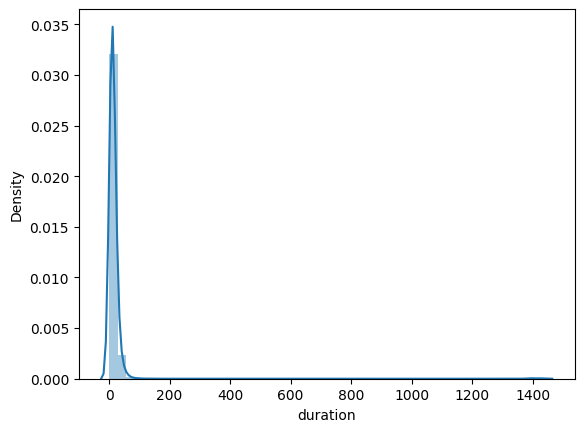

In [13]:
# Visualize Distribution of "duration"

sns.distplot(df.duration)

In [14]:
(df.duration).describe(percentiles=[0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

Target variable "duration" is highly skewed, hence a need for filtering.

In [15]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.9614860921999611)

In [16]:
# Filter duration (~96% of the dataset)

df = df[(df.duration >= 1) & (df.duration <= 60)]

df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000


In [17]:
# "Pick-up" & "Drop-off" location as Categorical features
categorical = ['PULocationID', 'DOLocationID']

# Numerical feature
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000


### Train the model


In [18]:
# Convert dict into vectors
train_dicts = df[categorical + numerical].to_dict(orient='records')

# train variables
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# Target
target = 'duration'
y_train = df[target].values


# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# prediction
y_pred = lr.predict(X_train)

# RMSE error of the LR model
root_mean_squared_error(y_train, y_pred)

7.1228220948023795

In [21]:
# Access features names

# dv.feature_names_

/tmp/ipykernel_89189/1742283376.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_89189/1742283376.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


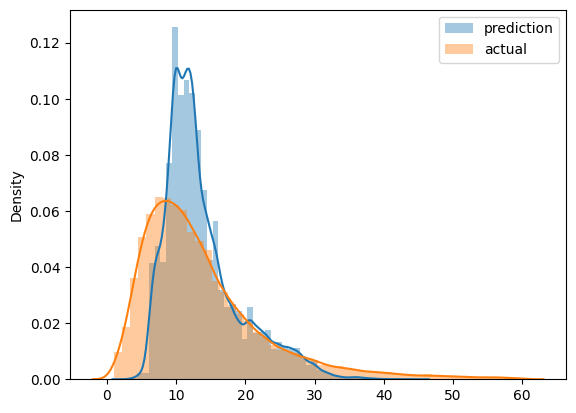

In [19]:
# Visualize predictions vs actual
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [20]:
# helper function

def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [21]:
df_train = read_dataframe('./data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-02.parquet')

In [22]:
len(df_train), len(df_val)

(54373, 51497)

In [23]:
# Create a Pick-up & drop-off feature
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [24]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [26]:
# Model 1: Linear Reg
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.9947992164797

In [30]:
# Save LR model & dv pre-processing
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [31]:
# Model 2: Lasso Reg
# Keep track of runs

with mlflow.start_run():
    # Set tags 
    mlflow.set_tag("developer", "Dan")

    # Log model metrics
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")


    alpha = 0.01

    # Log model parameters
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)

    # Log model metrics
    mlflow.log_metric("rmse", rmse)

    # Log model
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [32]:
# Model 3: XGBoost
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [33]:
# Convert data into DMatrix
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [34]:
# Define the search space

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [35]:
# Define the search space
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# Hyperopt optimization (minimize the objective function)
# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

### Training using Best parameters

Using best parameters from Mlflow UI, after sorting by `rmse`.

Retrain the model using the best params.

In [36]:
import mlflow.xgboost


with mlflow.start_run():

    # Train using the best parameters (Chosen myself as training was still ongoing)
    best_params = {
        'learning_rate': 0.3439932564910886,
        'max_depth': 6,
        'min_child_weight': 1.94094910358893,
        'objective': 'reg:linear',
        'reg_alpha': 0.06137291824802434,
        'reg_lambda': 0.053989087385761546,
        'seed': 42
    }

    mlflow.log_param("best_params", best_params)

    # mlflow.xgboost.autolog()
    # (params=params, artifact_path="models_xgboost")
    # Train the model
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=500,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(
        booster,
        artifact_path="models_xgboost_mlflow"
    )


[0]	validation-rmse:7.33266
[1]	validation-rmse:6.39635
[2]	validation-rmse:5.92862
[3]	validation-rmse:5.70402


/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:19:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[4]	validation-rmse:5.59316
[5]	validation-rmse:5.53415
[6]	validation-rmse:5.51050
[7]	validation-rmse:5.48807
[8]	validation-rmse:5.47608
[9]	validation-rmse:5.46831
[10]	validation-rmse:5.46353
[11]	validation-rmse:5.45993
[12]	validation-rmse:5.45723
[13]	validation-rmse:5.45402
[14]	validation-rmse:5.45121
[15]	validation-rmse:5.44849
[16]	validation-rmse:5.44609
[17]	validation-rmse:5.44170
[18]	validation-rmse:5.43339
[19]	validation-rmse:5.43162
[20]	validation-rmse:5.42976
[21]	validation-rmse:5.42896
[22]	validation-rmse:5.42692
[23]	validation-rmse:5.42485
[24]	validation-rmse:5.42175
[25]	validation-rmse:5.41858
[26]	validation-rmse:5.41589
[27]	validation-rmse:5.41519
[28]	validation-rmse:5.41386
[29]	validation-rmse:5.41297
[30]	validation-rmse:5.41112
[31]	validation-rmse:5.40936
[32]	validation-rmse:5.40812
[33]	validation-rmse:5.40324
[34]	validation-rmse:5.40268
[35]	validation-rmse:5.40200
[36]	validation-rmse:5.39905
[37]	validation-rmse:5.39541
[38]	validation-rmse

[116]	validation-rmse:5.28828
[117]	validation-rmse:5.28689
[118]	validation-rmse:5.28659
[119]	validation-rmse:5.28619
[120]	validation-rmse:5.28523
[121]	validation-rmse:5.28470
[122]	validation-rmse:5.28399
[123]	validation-rmse:5.28212
[124]	validation-rmse:5.28057
[125]	validation-rmse:5.27741
[126]	validation-rmse:5.27709
[127]	validation-rmse:5.27645
[128]	validation-rmse:5.27496
[129]	validation-rmse:5.27477
[130]	validation-rmse:5.27446
[131]	validation-rmse:5.27343
[132]	validation-rmse:5.27300
[133]	validation-rmse:5.27256
[134]	validation-rmse:5.27293
[135]	validation-rmse:5.27269
[136]	validation-rmse:5.27134
[137]	validation-rmse:5.27086
[138]	validation-rmse:5.26996
[139]	validation-rmse:5.26954
[140]	validation-rmse:5.26931
[141]	validation-rmse:5.26725
[142]	validation-rmse:5.26715
[143]	validation-rmse:5.26667
[144]	validation-rmse:5.26599
[145]	validation-rmse:5.25966
[146]	validation-rmse:5.25897
[147]	validation-rmse:5.25723
[148]	validation-rmse:5.25695
[149]	vali

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:19:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/05 13:19:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [37]:
## Use the MLFlow trained & tracked model

# Load the model
logged_model = 'runs:/7cb533e434ae47848cadd9c339f0adb0/models_xgboost_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# OR 
xgb_model = mlflow.xgboost.load_model(logged_model)

# Predict on a Pandas DataFrame.

y_pred = xgb_model.predict(valid)
y_pred[:10]

array([19.193127 , 27.792412 ,  6.7019396,  9.368691 ,  3.762924 ,
        4.994413 , 10.729384 , 18.40616  , 21.948484 ,  7.9763174],
      dtype=float32)

## MLflow Model Registry

Making sure production-ready models are registered into the registry.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

#mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2024-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2024-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)